<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/Santiago_V/KNN_vs_Tradicional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Demodulación

In [ ]:
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return(symbol)

In [ ]:
def SER_f(sym_rx, Symbols_tx, Ns):
    error = 0
    for i in range(Ns):
        if sym_rx[i] == Symbols_tx[i]:
            error = error
        else:
            error= error + 1
    SER = error/Ns
    return([SER, error])

# Generación y modulación

In [ ]:
Ns= 100000
Mod=16 #16QAM
Symbols_tx = np.random.randint(Mod, size=Ns)
df_sym_tx= pd.DataFrame(Symbols_tx)
print(Symbols_tx[0:10])

[ 3  5 11  7 11  6  6  0  7  6]


In [ ]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j, #1000
            9:3+1j, #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [ ]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(20)

0    -3.0-1.0j
1    -1.0+1.0j
2     3.0-1.0j
3    -1.0-1.0j
4     3.0-1.0j
5    -1.0-3.0j
6    -1.0-3.0j
7    -3.0+3.0j
8    -1.0-1.0j
9    -1.0-3.0j
10    3.0-1.0j
11    1.0+1.0j
12    1.0-1.0j
13    3.0+1.0j
14   -3.0-1.0j
15   -3.0+1.0j
16   -3.0-3.0j
17    1.0+1.0j
18   -1.0+3.0j
19    3.0-3.0j
Name: 0, dtype: complex128

# Transmisión canal AWGN

In [ ]:
Xr = np.real(df_sym_mod2)
Xi = np.imag(df_sym_mod2)

In [ ]:
# Adición de ruido blanco Gaussiano (AWGN)
l_snr=[]
dem_trad=[]
dem_knn=[]
neigh={}
best_neigh = {}

for count in range(6,20,2): #Adición ciclo for
  target_snr_db = count
  Xr_avg_p = np.mean(Xr**2)
  Xr_avg_db = 10 * np.log10(Xr_avg_p)
  #print(Xr_avg_db)
  noise_avg_db_r = Xr_avg_db - target_snr_db
  noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
  mean_noise = 0
  noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
  Xr_ch = Xr + noise_r

  Xi_avg_p = np.mean(Xi**2)
  Xi_avg_db = 10 * np.log10(Xi_avg_p)
  #print(Xi_avg_db)
  noise_avg_db_i = Xr_avg_db - target_snr_db
  noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
  noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
  Xi_ch = Xi + noise_i

  sym_rx= demapper_sym(Xr_ch, Xi_ch, len(Xr_ch), threshold = 2.0)
 
  #lista para la gráfica:
  l_snr.append(count)

  #-------------SIN KNN------------------
  SER, error = SER_f(sym_rx[:int(len(sym_rx)*.3)], Symbols_tx[:int(len(Symbols_tx)*.3)], int(Ns*.3))
  
  #------------USANDO KNN-----------------
  X = np.transpose(np.array([Xr_ch,Xi_ch]))
  y= Symbols_tx
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  best = [] #Resultado SER test segun vecino
  dic_sertest = {}

  for vecinos in range(2,11): #Iterar vecinos.
    k= vecinos # número de vecinos
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    model.score(X_train, y_train)
    y_pred = model.predict(X_test)    

    SER_test, error_test = SER_f(y_pred, y_test, len(y_pred))
    
    best.append(np.log10(SER_test))
    dic_sertest[vecinos] = np.log10(SER_test)
    
  neigh["snr: "+str(count)]=dic_sertest
  dem_trad.append(np.log10(SER))
  dem_knn.append(min(best))

  best_neigh[count]=best.index(min(best))+2
  
print(neigh) # Dic. SER_test para cada vecino y snr
print(best_neigh)#Dic. Mejores vecinos por cada snr 


{'snr: 6': {2: -0.2208365762355012, 3: -0.2351765214753958, 4: -0.25261408999258517, 5: -0.26262180100878124, 6: -0.26962153141235706, 7: -0.272675673286595, 8: -0.27937218709705, 9: -0.2811386240313042, 10: -0.2847210843595331}, 'snr: 8': {2: -0.32060238997263507, 3: -0.356119819730022, 4: -0.37362541060989696, 5: -0.3898013425132616, 6: -0.3976144098948949, 7: -0.4050920538917405, 8: -0.4095297064181503, 9: -0.41472731746646724, 10: -0.41646118074564786}, 'snr: 10': {2: -0.49889507304513653, 3: -0.5608779242543227, 4: -0.5733261119786272, 5: -0.5948244537820107, 6: -0.6011344832911745, 7: -0.6136794261059538, 8: -0.6130850719938874, 9: -0.6196681376843959, 10: -0.6225723189067117}, 'snr: 12': {2: -0.799696817018415, 3: -0.8881776119796476, 4: -0.8923378757231548, 5: -0.916139199133427, 6: -0.9148283902631877, 7: -0.9303319030884043, 8: -0.9309488864027199, 9: -0.9427143555817854, 10: -0.9410680995604578}, 'snr: 14': {2: -1.2515535412801915, 3: -1.359518563029578, 4: -1.35392317968766

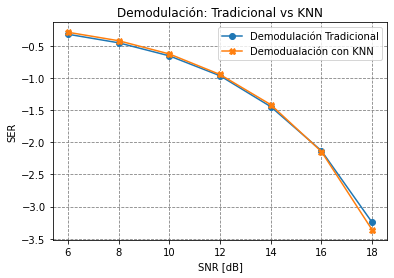

In [ ]:
fig, ax = plt.subplots()
dem = {"trad":dem_trad,"dem_knn":dem_knn}
ax.plot(l_snr,dem_trad, label = "Demodulación Tradicional", marker = 'o')
ax.plot(l_snr,dem_knn, label ="Demodualación con KNN", marker = 'X')
ax.legend(loc='upper right')
ax.grid(axis = 'both', color = 'gray', linestyle = 'dashed')
ax.set_title("Demodulación: Tradicional vs KNN")
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("SER")
plt.show()